In [1]:
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
sns.set_theme(style='whitegrid', context='paper', font_scale=1.75, rc={'axes.facecolor': 'white', 'figure.figsize':(7,4)})

### Figure 1. Gordon Bell Energy Use

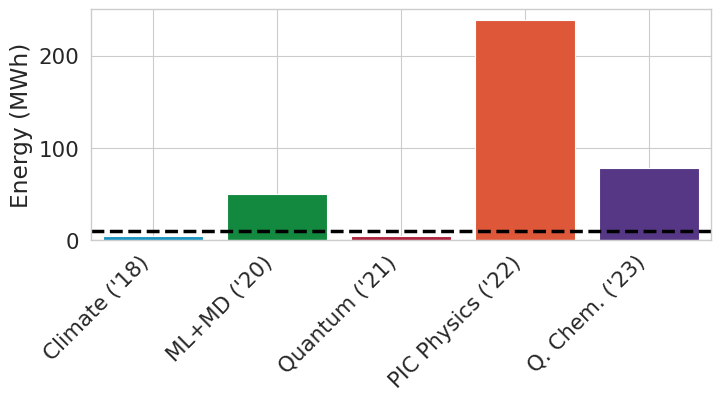

In [3]:
records = [
    ["Climate", 18, 4.985],
    ["ML+MD", 20, 50.480],
    ["Quantum", 21, 5.111],
    ["PIC Physics", 22, 238.325],
    ["Q. Chem.", 23, 78.432],
]
df = pd.DataFrame.from_records(records, columns=["Field", "Year", "Energy"])
df["Name"] = df["Field"] + " ('" + df["Year"].astype(str) + ")"
fig, ax = plt.subplots()
fig.set_size_inches(8,3)

colors = ["#00a1de", "#009b3a", "#c60c30", "#f9461c", "#532A92"]
sns.barplot(data=df[["Name", "Energy"]], x="Name", y="Energy", ax=ax, palette=colors)
ax.set_ylabel("Energy (MWh)")
ax.set_xlabel(None)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.grid(True)
ax.axhline(y=10.500, color='black', linestyle="--", linewidth=2.5)
plt.savefig('figures/gordon_bell_energy.pdf', bbox_inches='tight')

## Section 6. Prototype Evaluation

In [4]:
def read_jsonl(filepath):
    with open(filepath) as fp:
        records = fp.readlines()
        df = pd.DataFrame.from_records([json.loads(r) for r in records])
    return df

In [5]:
endpoint_id_map = {
    "d0ac23c8-a873-43e8-b5c4-0c7199092d0e": "Cascade Lake",
    "6754af96-7afa-4c81-b7ef-cf54587f02fa": "Desktop",
    "a02544c2-997d-4169-a8e3-b5d676d9e661" : "Ice Lake",
    "1a302149-7bef-40fe-9dc1-08ae540dc719": "Zen3"
}

strategy_map = {
    "MinCredit": "Greedy",
    "MinEnergy": "Energy",
    "MinRuntime": "Runtime"
}

In [6]:
runs = ["2d981fd3-7537-4988-ae5f-8c5cc041f151", "90fd518b-ea2b-43cf-a659-5049110ebe6a", "e5767848-ed79-4272-8e51-95b50aa3169e"]

# Average the last row of all three runs to create figures
rows = []
for run in runs:
    for user in range(3):
        df = read_jsonl(f"results/run-{run}/users-3-strategy-rr-endpoints-4/user_{user}_trace.jsonl")
        rows.append(df.iloc[-1])
df = pd.DataFrame.from_records(rows)
df = df.rename(columns=endpoint_id_map)
df["strategy"] = df["strategy"].replace(strategy_map)

df["energy_consumed"] *= (1000 * 3600)
df["core_hours_consumed"] *= 3600

### Figure 11. Prototype Workload Results

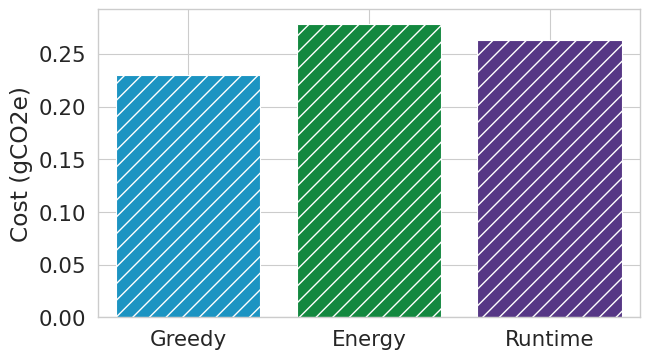

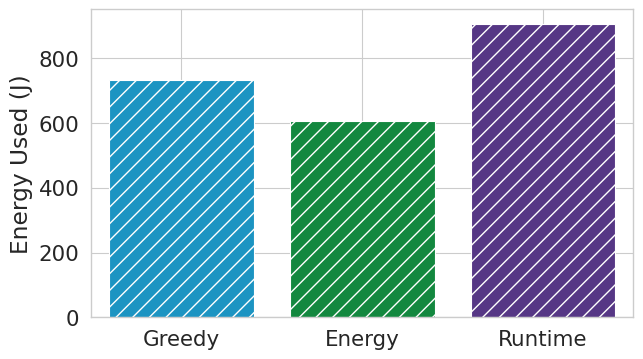

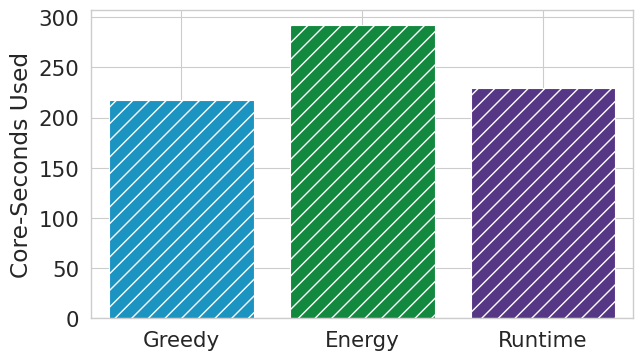

In [7]:
colors = ["#00a1de", "#009b3a", "#532A92"]
hatch_style = "//"

fig, ax = plt.subplots()
sns.barplot(df, x="strategy", y="credits_consumed", palette=colors, errorbar=None, hatch=hatch_style, ax=ax)
ax.xaxis.grid(True)
plt.xlabel(None)
plt.ylabel('Cost (gCO2e)')
plt.savefig("figures/prototype_credits_barplot.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
sns.barplot(df, x="strategy", y="energy_consumed", palette=colors, errorbar=None, hatch=hatch_style, ax=ax)
ax.xaxis.grid(True)
plt.xlabel(None)
plt.ylabel('Energy Used (J)')
plt.savefig("figures/prototype_energy_barplot.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
sns.barplot(df, x="strategy", y="core_hours_consumed", palette=colors, errorbar=None, hatch=hatch_style, ax=ax)
ax.xaxis.grid(True)
plt.xlabel(None)
plt.ylabel('Core-Seconds Used')
plt.savefig("figures/prototype_time_barplot.pdf", bbox_inches='tight')
plt.show()

### Figure 12. Prototype Task Distribution

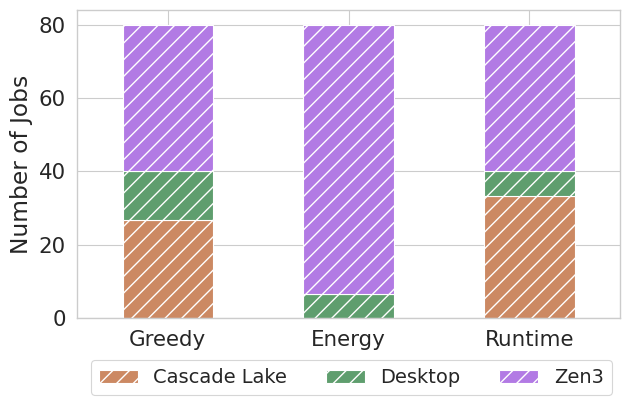

In [17]:
df = df.fillna(0)
df_avg = df[["strategy","Cascade Lake", "Desktop", "Zen3"]].groupby("strategy", sort=False).mean()

hatch_style = "//"
colors = ["#CC8963", "#5F9E6E", "#B27AE4"]
df_avg.plot(kind="bar", stacked=True, color=colors, hatch=hatch_style)
plt.legend(['Cascade Lake', 'Desktop', 'Zen3'], ncol=3, loc=(0.025, -0.25), fontsize=14)
plt.xlabel(None)
plt.ylabel('Number of Jobs')
plt.xticks(rotation=360)

plt.savefig("figures/prototype_machine_dist_barplot.pdf", bbox_inches='tight')

In [594]:
df[["strategy","credits_consumed", "energy_consumed"]].groupby("strategy").mean()

,credits_consumed,energy_consumed
strategy,,
Credit,0.230011,733.4160
Energy,0.278093,606.5664
Runtime,0.263021,905.5416


In [590]:
jobs = pd.read_csv("results/job_log.csv", index_col=0)
jobs["endpoint_id"] = jobs["endpoint_id"].replace(endpoint_id_map)

jobs["power"] = jobs["energy_consumed"] / jobs["running_duration"]
jobs["predicted_power"] = jobs["predicted_energy"] / jobs["predicted_runtime"]
jobs["adj_power"] = jobs["power"]
jobs.loc[jobs["endpoint_id"] == "Desktop", ["adj_power", "predicted_power"]] += (5/16)
jobs.loc[jobs["endpoint_id"] == "Cascade Lake", ["adj_power", "predicted_power"]] += (136/48)
jobs.loc[jobs["endpoint_id"] == "Ice Lake", ["adj_power", "predicted_power"]] += (190/80)
jobs.loc[jobs["endpoint_id"] == "Zen3", ["adj_power", "predicted_power"]] += (120/128)
jobs["energy_consumed"] = jobs["adj_power"] * jobs["running_duration"]
jobs["predicted_energy"] = jobs["predicted_power"] * jobs["predicted_runtime"]

jobs["energy_credit_per_sec"] = 0
jobs.loc[jobs["endpoint_id"] == "Desktop", "energy_credit_per_sec"] = (65/16) + jobs.loc[jobs["endpoint_id"] == "Desktop", "adj_power"]
jobs.loc[jobs["endpoint_id"] == "Cascade Lake", "energy_credit_per_sec"] = (410/48) + jobs.loc[jobs["endpoint_id"] == "Cascade Lake", "adj_power"]
jobs.loc[jobs["endpoint_id"] == "Ice Lake", "energy_credit_per_sec"] = (410/80) + jobs.loc[jobs["endpoint_id"] == "Ice Lake", "adj_power"]
jobs.loc[jobs["endpoint_id"] == "Zen3", "energy_credit_per_sec"] = (560/128) + jobs.loc[jobs["endpoint_id"] == "Zen3", "adj_power"]
jobs.loc[:, "energy_credit_per_sec"] /= 2
jobs["energy_credit"] = jobs["energy_credit_per_sec"] * jobs["running_duration"]

cpu_single_thread_perf = {
    "Desktop": 2907,
    "Cascade Lake": 2286,
    "Ice Lake": 2385,
    "Zen3": 2527
}
jobs["CPU_Perf"] = jobs["endpoint_id"]
jobs["CPU_Perf"] = jobs["CPU_Perf"].replace(cpu_single_thread_perf)
jobs["peak_perf_charge"] = jobs["running_duration"] * jobs["CPU_Perf"]

In [596]:
jobs

,task_id,endpoint_id,user_id,function_id,task_status,predicted_runtime,predicted_energy,predicted_credits,running_duration,energy_consumed,...,ref_cycles,time_completed,name,power,predicted_power,adj_power,energy_credit_per_sec,energy_credit,CPU_Perf,peak_perf_charge
0,12462cec-90da-4afe-96f6-0690360c6b59,Zen3,user_1,c9a8018d-6dc9-43b6-9f88-a93882a72071,finished,5.457370,22.897384,0.005433,6.040090,14.146964,...,0.000000e+00,2024-03-21 19:30:29,cholesy_decomposition,1.404678,4.195681,2.342178,3.358589,20.286179,2527,15263.307430
1,22e90339-25da-4c94-bba8-956014361ace,Zen3,user_0,a793b0c5-8696-4b44-970a-1456b20b0af7,finished,0.649891,1.780963,0.000524,0.594911,0.569436,...,0.000000e+00,2024-03-21 19:30:29,molecular_dynamics_ie,0.019678,2.740402,0.957178,2.666089,1.586086,2527,1503.340097
2,49f3530b-55de-4f22-b554-a67cd03d7d34,Zen3,user_2,1947b1b3-7862-442d-abe2-21c4773c3c53,finished,3.325090,19.301872,0.004008,3.210670,15.475103,...,0.000000e+00,2024-03-21 19:30:29,graph_pagerank,3.882398,5.804917,4.819898,4.597449,14.760892,2527,8113.363090
3,9d61e676-c35d-4bc8-99fb-0232c35ece67,Zen3,user_2,1bafe132-62fe-4ceb-b01c-d4b39f41c31d,finished,3.325090,19.301872,0.004008,3.342990,16.937053,...,0.000000e+00,2024-03-21 19:30:29,graph_pagerank,4.128938,5.804917,5.066438,4.720719,15.781317,2527,8447.735730
4,b96cf85e-9097-43f7-b689-d890d2079db6,Zen3,user_1,3f4d0194-42d1-43ec-b203-80e9145c4a87,finished,5.457370,22.897384,0.005433,6.161530,12.855474,...,0.000000e+00,2024-03-21 19:30:29,cholesy_decomposition,1.148909,4.195681,2.086409,3.230705,19.906084,2527,15570.186310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,97688597-1e95-4db7-99cc-c31af0a7516a,Desktop,user_0,57b55535-8b3d-47b5-b9bd-53ed8888b34f,finished,23.032000,118.875500,0.025029,14.733900,61.298144,...,3.840230e+10,2024-03-21 14:01:41,dna_visualization,3.847847,5.161319,4.160347,4.111424,60.577306,2907,42831.447300
1317,a3589052-3330-4acc-b2dc-ac348a220bf9,Desktop,user_0,f39e202a-aee1-4ee3-9b4b-3f20966d4cf8,finished,14.586100,26.859256,0.009945,16.152700,16.524419,...,3.585580e+09,2024-03-21 14:01:41,molecular_dynamics_ie,0.710513,1.841428,1.023013,2.542756,41.072381,2907,46955.898900
1318,c5e6a388-21f7-4d0e-aad4-1e2284670f3f,Desktop,user_0,87d9095f-ed3e-4001-89ff-df3c2e6b0274,finished,8.197210,17.427528,0.005874,5.363000,7.643928,...,3.897470e+09,2024-03-21 14:01:41,cholesy_decomposition,1.112808,2.126032,1.425308,2.743904,14.715558,2907,15590.241000
1319,8c72663f-f427-4e72-a61a-3d0912cc0fa7,Desktop,user_0,e5046ab2-9e41-42ec-ac79-5af03884e79a,finished,8.197210,17.427528,0.005874,3.889050,11.401028,...,3.755990e+09,2024-03-21 14:01:13,cholesy_decomposition,2.619071,2.126032,2.931571,3.497036,13.600147,2907,11305.468350


### Table VI: Stability 

In [570]:
pred_jobs = jobs[:240] # Limit to jobs in the workload

def smae(df, c1, c2):
    return np.mean(np.abs(df[c1] - df[c2])/(df[c1] + df[c2]))

print("Runtime Prediction Error: ", smae(pred_jobs, "running_duration", "predicted_runtime"))
print("Runtime Prediction Error: ", smae(pred_jobs, "energy_consumed", "predicted_energy"))
print("Runtime Prediction Error: ", smae(pred_jobs, "credits_consumed", "predicted_credits"))

Runtime Prediction Error:  0.07967244502658158
Runtime Prediction Error:  0.25750442731276413
Runtime Prediction Error:  0.09407558395755093


In [571]:
perc_dev = pred_jobs.groupby(["endpoint_id", "name"]).std(numeric_only=True)[["running_duration", "energy_consumed", "credits_consumed"]] / jobs.groupby(["endpoint_id", "name"]).mean(numeric_only=True)[["running_duration", "energy_consumed", "credits_consumed"]]
perc_dev.mean(axis=0)

running_duration    0.088987
energy_consumed     0.205613
credits_consumed    0.117593
dtype: float64

### Table V: Worked Cost Example

In [569]:
grouped_df = jobs.groupby(["endpoint_id", "name"]).mean(numeric_only=True)[["running_duration", "energy_consumed", "adj_power", "energy_credit", "peak_perf_charge", "credits_consumed"]]
grouped_df.loc[(slice(None), "cholesy_decomposition"),  :]

,,running_duration,energy_consumed,adj_power,energy_credit,peak_perf_charge,credits_consumed
endpoint_id,name,,,,,,
Cascadelake,cholesy_decomposition,4.608795,35.808279,7.822635,37.587536,10535.706107,0.005789
Desktop,cholesy_decomposition,5.199127,18.304929,3.683085,19.713191,15113.862001,0.004874
Icelake,cholesy_decomposition,4.688185,19.702729,4.203475,21.864839,11181.321225,0.005348
Zen3,cholesy_decomposition,5.650340,16.845520,3.024161,20.782880,14278.410444,0.005492


## Additional Figures:

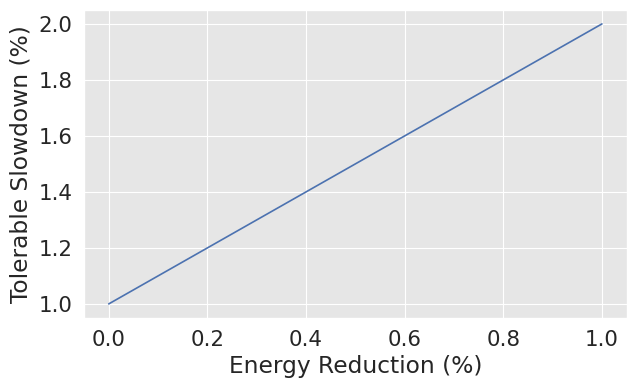

In [538]:
x = np.linspace(0, 1, 100)
y = 2/(1+x)
energy_reduction = (1- (x * y))
sns.lineplot(x=energy_reduction, y=y)
plt.xlabel("Energy Reduction (%)")
plt.ylabel("Tolerable Slowdown (%)")
plt.savefig('figures/energy_slowdown_tradeoff.pdf', bbox_inches='tight')